# Temporal Difference Learning Introduction.

---

I highly recommend to visit the David Silver Lectures on Temporal Difference Reinforcement Learning: https://www.youtube.com/watch?v=PnHCvfgC_ZA&t


The Temporal Difference is class of model-free reinforcement learning method. Even though these methods learn directly from experiencie (trial and error) as explained in the MonteCarlo section, its difference with MonteCarlo is based on the fact that they don't have to wait until the end of an episode. Instead, they can update the action-value function after each step of the episode. In its most basic form, a TD algorithm uses the following formula to perform a state-value update:

$V(S_{t}) = V(S_{t}) + \alpha [r_{t+1} + \gamma V(S_{t+1}) - V{S_{t}}]$

Where $\alpha$ is called step size (learning rate) and it's in the range of $[0, 1]$.

In this notebook, we first consider the problem of the policy evaluation using temporal difference learning, then, we continue with policy control.

<img src = "./imagenes/temporal_difference_backup.png" width = "500px" height = "450px">

### 1. Policy Evaluation (Prediction) for Temporal Difference Learning.

<img src = "./imagenes/temporal_difference_policy_evaluation_algorithm.png" width = "650px">

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [2]:
class Graphics():
    
    def __init__(self):
        print("Graphics module ready!")
        
    def render(self, x, y, policy_evaluator, plot_values = True):
            
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

         # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.2, 0.8), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#F6D924"))
        
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))
        
        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.8, 0.4), 0.2, 0.2, facecolor = "#33A4FF"))
        
        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot player.
        plt.scatter(x, y, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        if plot_values:
            for i in range(0, len(policy_evaluator.value_state_table)):
                for j in range(0, len(policy_evaluator.value_state_table[0])):
                    plt.text(self.environment.grid_pos[i] - 0.08, self.environment.grid_pos[j] - 0.03, 
                             round(policy_evaluator.value_state_table[i][j], 1), fontsize=10)
                
        # Plot grid.
        plt.axis("off")
        plt.show()  

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 1]]
        self.rewards = [[self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw], 
                        [self.rw, self.rw, self.rw, self.rw, self.rw]]
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]

In [4]:
class modelFreeAgent():
    
    def __init__(self, policy, discount_factor):
        self.pos = [0,0]
        self.total_reward = 0
        self.discount_factor = discount_factor
        self.actions = ["up", "down", "left", "right"]
        
        # Start with a random policy. 0.25 chance of moving to any direction.
        self.policy = policy   
        
    # Move!
    def move(self, environment):
    
        # Select action according to policy.
        action = self.policy[self.pos[0]][self.pos[1]]
        if action == "r":
            action = self.actions[random.randint(0, 3)]

        # Move to new position according to action taken.
        self.pos = self.forwardState(self.pos, action, environment)
        
    # Select action according to policy.
    def selectAction(self, state):
        
        if(self.policy[state[0]][state[1]] == "r"):
            action = self.actions[random.randint(0, len(self.available_actions) - 1)] # Agent initial policy.
        else: 
            action = self.policy[state[0]][state[1]]
        return action
            
    def forwardState(self, pos, action, environment):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(environment.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]
        elif(action == "down" and pos[1] > 0):
            if(environment.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]
        elif(action == "left" and pos[0] > 0):
            if(environment.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]
        elif(action == "right" and pos[0] < 4):
            if(environment.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position

    def getPosition(self):
        return self.pos
    
    def getReward(self):
        return self.total_reward
    
    def setPosition(self, x, y):
        self.pos = [x, y]

In [9]:
class PolicyEvaluation(Graphics):
    
    def __init__(self, environment, agent, ephocs = 10, learning_rate = 0.5, steps = 0):
        
        self.environment = environment       
        self.agent = agent                     
        self.ephocs = ephocs
        self.value_state_table = [[0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 0, 0], 
                                  [0, 0, 0, 100, 0]]
        self.learning_rate = learning_rate
        self.steps = 0
    
    def evaluate(self, plot_grid = True):
        self.updateValueStateTable_TemporalDifference(plot_grid, self.ephocs, self.steps)
        
    def updateValueStateTable_TemporalDifference(self, plot_grid, ephocs, n = 0):
        
        # Set agent position in the initial state.
        self.agent.setPosition(0, 0)
        
        # Generate k epochs.
        for k in range(0, ephocs):
            
            # Continue until get to the terminal state.
            while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
                
                # Previous position.
                pre = self.agent.pos.copy()
                
                # Move the player.
                self.agent.move(self.environment)
                
                # Compute TD target.
                reward = self.environment.rewards[self.agent.pos[0]][self.agent.pos[1]]
                new_state_value = self.value_state_table[self.agent.pos[0]][self.agent.pos[1]]
                TD_target = reward + self.agent.discount_factor * new_state_value
                
                # Compute TD error.
                TD_error = TD_target - self.value_state_table[pre[0]][pre[1]]
                
                # Update value state table.
                self.value_state_table[pre[0]][pre[1]] = (self.value_state_table[pre[0]][pre[1]] +
                                                         self.learning_rate * (TD_error))
                
                # Method of the super class.
                if(plot_grid):

                    # Render game.
                    pos = self.agent.getPosition()
                    grid_coords = self.environment.grid_pos

                    self.render(self.environment.grid_pos[pos[0]], self.environment.grid_pos[pos[1]], self, True)
                    time.sleep(0.1)
                    clear_output(wait = True)
                    
            # Set players position at the beginning.
            self.agent.setPosition(0, 0)
            
    def plotTable(self):
        # Render game.
        grid_coords = self.environment.grid_pos
        self.render(self.environment.grid_pos[0], self.environment.grid_pos[0], self, True)


In [10]:
class Game(Graphics):
    
    def __init__(self, environment, agent):
        
        self.environment = environment       
        self.agent = agent             
        
    def update(self, secs):
        
        pos = self.agent.getPosition()
        grid_coords = self.environment.grid_pos
        self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
        time.sleep(1)
        clear_output(wait = True)
        
        while not (self.agent.pos[0] == 4 and self.agent.pos[1] == 3):
            
            self.agent.move(self.environment)
            pos = self.agent.getPosition()
            self.render(grid_coords[pos[0]], grid_coords[pos[1]], self.environment, False)
            
            time.sleep(secs)
            clear_output(wait = True)

#### 1.1 Policy Evaluation - Temporal Difference Learning, TD(0)

In [13]:
# Generate the random policy.
policy = list()
for i in range(0, 5):
    column = list()
    for j in range(0, 5):
        column.append("r")
    policy.append(column)

# Initialize environment and agent.
discount_factor = 0.9
environment = GridEnvironment()
agent = modelFreeAgent(policy, discount_factor)

# Initialize policy evaluation class.
ephocs = 10000
learning_rate = 0.5
steps = 0
policy_evaluation = PolicyEvaluation(environment, agent, ephocs, learning_rate, steps)
policy_evaluation.evaluate(plot_grid = False)

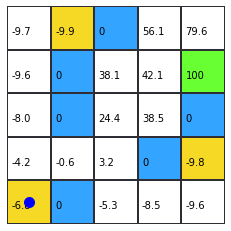

In [14]:
# Plot policy evaluation result.
policy_evaluation.plotTable()

## TD(n).

---

In the previous example, we updated our value function table after observing what happened one step in the future, however, we could have done the same after considering $n$-steps in the future, i.e, we can generalize this process as indicated in the image (we will incorporate this functionality in future versions of this notebook):

<img src = "./imagenes/n_step_return_temporal_difference_learning.png" width = "400px" >

## TD($\lambda$).

---

Another approach to compute the value function is to average the $n$-step returns. The natural question that arrises from the latter proposal is: Can we efficiently combine information from all time-steps? The answer is **Yes, we can**, using the TD($\lambda$) algorithm (we will incorporate this functionality in future versions of this notebook):

<img src = "./imagenes/lambda_return_temporal_difference.png" width = "500px" >
<img src = "./imagenes/forward_view_lamda_return_temporal_difference.png" width = "500px">